In [ ]:
# Installing required packages
!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant
!pip install pyLDAvis
!pip install top2vec

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.co

In [ ]:
# Import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import enchant
from gensim import corpora
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm

import pyLDAvis
import pyLDAvis.gensim_models

from top2vec import Top2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load spacy "en_core_web_sm" model 
nlp = spacy.load("en_core_web_sm")

In [ ]:
## mount the working directory
drive.mount("text_clustering")

Mounted at text_clustering


In [ ]:
## read the dataset
df = pd.read_excel("/content/text_clustering/MyDrive/text_clustering/data.xlsx")

In [ ]:
## pre-define function for cleaning the tweets
d = enchant.Dict("en_US")
lemmetizer = WordNetLemmatizer()
def clean_tweet(text):
    clean_text = text.lower()
    clean_text = re.sub("'", "", clean_text) # to avoid removing contractions in english
    clean_text = re.sub("@[A-Za-z0-9_]+","", clean_text)
    clean_text = re.sub("#[A-Za-z0-9_]+","", clean_text)
    clean_text = re.sub(r'http\S+', '', clean_text)
    clean_text = re.sub('[()!?]', ' ', clean_text)
    clean_text = re.sub('\[.*?\]',' ', clean_text)
    clean_text = re.sub("[^a-zA-Z]"," ", clean_text)
    clean_text = clean_text.strip().split()
    clean_text = [i for i in clean_text if d.check(i)==True and len(i)>2 ]
    clean_text_2 = [lemmetizer.lemmatize(word) for word in clean_text if word not in set(stopwords.words("english"))]
    if len(clean_text_2)>2:
      clean_text_3 = " ".join(clean_text_2)
    else:
       clean_text_3 = np.nan

    return clean_text_3

In [ ]:
# filter required columns
df_1 = df[['content', 'key']]
df_sample = df_1.sample(frac=0.99,random_state=0) # To sheffle the dataset

# apply the pre-defined cleaning function
df_sample["content_clean"] = df_sample["content"].apply(lambda x: clean_tweet(x))


In [ ]:
# df_sample

In [ ]:
# Ge the required pos tag -(part of speech tag) in a text.
def get_requied_pos_tag(texts):
    texts_out = []
    for text in texts:
        # print(text)
        doc = nlp(text)
        new_text = []
        for token in doc:
            # if token.pos_ in "NOUN":
            if token.pos_ in (("NOUN", "ADJ")):
                # print(token.lemma_)
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

In [ ]:
## drop duplicates and null raws
df_sample_1 = df_sample.drop_duplicates(subset=["content_clean"])
df_sample_2= df_sample_1[df_sample_1["content_clean"].notna()]

In [ ]:
# check the shape of the orginal and cleaned dataframe
df_sample.shape, df_sample_1.shape, df_sample_2.shape

((22175, 3), (21720, 3), (21719, 3))

In [ ]:
# save clean dataframe
# df_sample_2.to_excel("/content/text_clustering/MyDrive/text_clustering/data_clean.xlsx")

In [ ]:
# list of data
data = df_sample_2["content_clean"].tolist()

In [ ]:
# apply the get_requied_pos_tag function
data_pos = get_requied_pos_tag(data)

In [ ]:
# add extracted pos tags to the df_sample dataframe
df_sample_2["content_clean_pos"] = data_pos

In [ ]:
# df_sample.head(5)

In [ ]:
# Remove duplicates and nan based on "content_clean_pos" column
df_sample_3 = df_sample_2.drop_duplicates(subset=["content_clean_pos"])
df_sample_4 = df_sample_3.loc[df_sample_3["content_clean_pos"].notna()]

In [ ]:
# check the shape
df_sample_4.shape

(20637, 4)

In [ ]:
# split the clean text in "content_clean_pos" column
df_sample_4["content_clean_pos_words"] = df_sample_4["content_clean_pos"].apply(lambda x: x.split(" "))

In [ ]:
# list of data for LDA model
data = df_sample_4["content_clean_pos_words"].tolist()

In [ ]:
#  data[5:10]

In [ ]:
#############  bigrams and trigrams

bigram_phrases = gensim.models.Phrases(data, min_count=2,threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data],min_count=2,threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram= gensim.models.phrases.Phraser(trigram_phrases)

output =[trigram[bigram[d]] for d in data]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
############# LDA model
# This LDA model is fitted by using original data not using any output of bigram and trigram
# If it wish to perform the LDA model using bigram and trigrma , we can use the above output from bigram and trigram instead of data in below model
 
dictionary = corpora.Dictionary(data)
# dictionary = corpora.Dictionary(output)

doc_term_matrix = [dictionary.doc2bow(text) for text in data]

LDA = gensim.models.ldamodel.LdaModel
### base model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, random_state=0,
                chunksize=200, passes=100)


In [ ]:
# To evaluate the base LDA model 
# coherence parameter in the CoherenceModel has many choices, as c_v, u_mass
# "c_v" is required more excution time , "u_mass" is used for this usecase

coherence_model_lda = CoherenceModel(model=lda_model,texts=data, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -11.553974115405


In [ ]:
# Visualize the base LDA model

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary,mds='mmds',R=50,)
pyLDAvis.save_html(vis, '/content/text_clustering/MyDrive/text_clustering/lda_with_noun_adj.html')
pyLDAvis.display(vis)

In [ ]:
########### Evaluate the  and find the optimal number of topics for LDA model
# since u_mass has used in coherence, optimal number of topic is the minimum (lowest) value of Coherence score in the below plot.

topics = []
score = []
for i in tqdm(range(10,50,5)):
    print(i)
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=i, random_state=0,
                chunksize=200, passes=100 )
    coherence_model = CoherenceModel(model=lda_model,texts=data , dictionary=dictionary, coherence='u_mass')
    topics.append(i)
    score.append(coherence_model.get_coherence())
    # print(i,coherence_model.get_coherence() )

  0%|          | 0/8 [00:00<?, ?it/s]

10


 12%|█▎        | 1/8 [07:55<55:27, 475.29s/it]

15


 25%|██▌       | 2/8 [16:50<51:01, 510.26s/it]

20


 38%|███▊      | 3/8 [27:18<47:01, 564.24s/it]

25


 50%|█████     | 4/8 [38:56<41:07, 616.86s/it]

30


 62%|██████▎   | 5/8 [52:09<34:01, 680.39s/it]

35


 75%|███████▌  | 6/8 [1:06:42<24:52, 746.16s/it]

40


 88%|████████▊ | 7/8 [1:22:58<13:41, 821.04s/it]

45


100%|██████████| 8/8 [1:41:38<00:00, 762.35s/it]


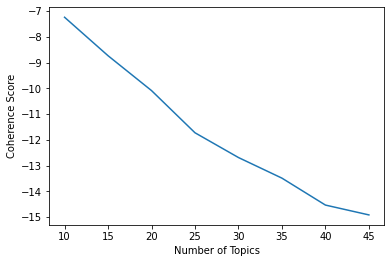

In [ ]:
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.savefig("/content/text_clustering/MyDrive/text_clustering/Number_of_Topics_Vs_Coherence_score")
plt.show()

# The plot is not converge at a point. Because if the number of topics extended even more, the coherence score decreases. 
# Therefore this model is not working as we expected, because we have only 9 keywords in our dataset

In [ ]:
########################## implement Top2vec model

In [ ]:
# The list of original column 
docs = df_sample_4.content.tolist()

In [ ]:
# Initialize the Top2Vec model
# This model is not required any kind of clean or preprocessing
model_top2vec = Top2Vec(docs)

2022-11-27 11:46:59,207 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-11-27 11:47:03,586 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-11-27 11:48:47,608 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-11-27 11:49:12,727 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-11-27 11:49:15,882 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
topic_sizes, topic_nums = model_top2vec.get_topic_sizes()
print(topic_sizes)
print(topic_nums)
# There are 9 topics found from Top2Vec model

[18963  1229   650   368   282   198   173   167   145]
[0 1 2 3 4 5 6 7 8]


In [ ]:
topic_words, word_scores, topic_nums = model_top2vec.get_topics(2)

In [ ]:
for words, score, nums in zip(topic_words, word_scores, topic_nums):
    print(nums)
    print(f"Words : {words}")
# The words given by the Topic 0 is not useful to decide the cluster and in Topic to there are multiple clusters

0
Words : ['and' 'the' 'even' 'both' 'with' 'these' 'have' 'up' 'from' 'for' 'which'
 'to' 'out' 'as' 'all' 'that' 'way' 'others' 'yet' 'in' 'very' 'is' 'also'
 'this' 'of' 'not' 'are' 'still' 'would' 'where' 'under' 'then' 'hard'
 'well' 'but' 'become' 'just' 'list' 'again' 'people' 'times' 'big'
 'making' 'part' 'be' 'first' 'one' 'give' 'ever' 'other']
1
Words : ['ems' 'unit' 'location' 'rd' 'st' 'ave' 'amb' 'medic' 'township' 'main'
 'dr' 'reason' 'ln' 'mad' 'fire' 'responding' 'east' 'id' 'hwy' 'park'
 'west' 'emergency' 'respond' 'scene' 'medical' 'th' 'closed' 'injury'
 'rescue' 'blvd' 'vehicle' 'south' 'near' 'wb' 'minor' 'river' 'san'
 'cleared' 'highway' 'involving' 'king' 'accident' 'reported' 'pm' 'city'
 'north' 'lanes' 'sb' 'loop' 'area']


#### Try to fit Top2Vec model for cleaned and preprocessed data 

In [53]:
docs_1 = df_sample_4["content_clean_pos"].tolist()

In [54]:
model_top2vec_1 = Top2Vec(docs_1)

2022-11-27 12:59:14,889 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-11-27 12:59:16,321 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-11-27 13:00:20,514 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-11-27 13:00:50,674 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-11-27 13:00:55,434 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [58]:
topic_sizes_1, topic_nums_1 = model_top2vec_1.get_topic_sizes()
print(topic_sizes_1)
print(topic_nums_1)
# There are 24 topics , it's fine
# But the words in the each cluster does not give any idea to group those clusters under any specific keywords like BERTopic model

[8637 1820 1588 1279 1067  980  636  536  441  424  385  371  342  303
  296  253  236  198  183  160  150  130  118  104]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [59]:
topic_words_1, word_scores_1, topic_nums_1 = model_top2vec_1.get_topics(10)

In [60]:
for words, score, nums in zip(topic_words_1, word_scores_1, topic_nums_1):
    print(nums)
    print(f"Words : {words}")
# By looking at the below cluster, we cant come to conclusion regarding the topic 
# Therefore BERTopic model is perform well. Moreover, we can merge the similar topics together in this topic modeling.

0
Words : ['leak' 'expert' 'franchise' 'massive' 'definition' 'photo' 'harm' 'rest'
 'key' 'block' 'process' 'eye' 'joke' 'fight' 'heavy' 'view' 'practice'
 'dangerous' 'ticket' 'capitalism' 'politic' 'citizen' 'weather' 'cut'
 'hard' 'impact' 'question' 'position' 'character' 'look' 'cop' 'full'
 'concern' 'decade' 'vote' 'discussion' 'nation' 'result' 'dude' 'purpose'
 'multiple' 'main' 'surgery' 'research' 'conservative' 'respect'
 'disgusting' 'son' 'land' 'love']
1
Words : ['medic' 'employee' 'message' 'auto' 'material' 'animal' 'fan' 'yesterday'
 'blood' 'benefit' 'ready' 'strong' 'act' 'card' 'trauma' 'suicide' 'link'
 'behavior' 'genocide' 'word' 'innocent' 'court' 'disabled' 'thank' 'sad'
 'head' 'common' 'self' 'religious' 'lie' 'mental' 'eye' 'room' 'north'
 'study' 'medium' 'serious' 'living' 'citizen' 'aid' 'unemployment'
 'close' 'wife' 'growth' 'interest' 'work' 'injury' 'respect' 'heart'
 'blvd']
2
Words : ['bus' 'exit' 'location' 'pure' 'pregnant' 'station' 'response' 